# A2: Vector Semantics

Nikolai Ilinykh, Mehdi Ghanimifard, Wafia Adouane and Simon Dobnik

The lab is an exploration and learning exercise to be done in a group and also in discussion with the teachers and other students.

Before starting, please read [the following instructions](https://github.com/sdobnik/computational-semantics/blob/master/README.md) on how to work on group assignments.

Write all your answers and the code in the appropriate boxes below.

In this lab we will look at how to build distributional semantic models from corpora and use semantic similarity captured by these models to do semantic tasks. We are also going to examine how different vector composition functions for phrases affect both the model and the learned information about similarities.  

Note that this lab uses a code from `dist_erk.py`, which contains functions that highly resemble those shown during the lecture. In the end, you can use either of the functions (from the lecture / from the file) to solve the tasks.

In [2]:
# the following command simply imports all the methods from that code.
from dist_erk import *

## 1. Loading a corpus

To train a distributional model, we first need a sufficiently large collection of texts which contain different words used frequently enough in different contexts. Here we will use a section of the Wikipedia corpus which you can download from [here](https://linux.dobnik.net/cloud/index.php/s/isMBj49jt5renYt?path=%2Fresources%2Fa2-distributional-representations) (wikipedia.txt.zip). (This file has been borrowed from another lab by [Richard Johansson](http://www.cse.chalmers.se/~richajo/)).  
When unpacked, the file is 151mb, hence if you are using the MLT servers you should store it in a temporary folder outside your home and adjust the `corpus_dir` path below.  
<!-- <It may already exist in `/opt/mlt/courses/cl2015/a5`.> -->


In [3]:
#corpus_dir = '/Users/xilini/Desktop/wikipedia/'
corpus_dir = 'wikipedia'
#corpus_dir = 'C:/Users/bamsh/Desktop/assignment2extras/wikipedia'

## 2. Building a model

Now you are ready to build the model.  
Using the methods from the code imported above build three word matrices with 1000 dimensions as follows:  

(i) with raw counts (saved to a variable `space_1k`);  
(ii) with PPMI (`ppmispace_1k`);  
(iii) with reduced dimensions SVD (`svdspace_1k`).  
For the latter use `svddim=5`. **[5 marks]**

Your task is to replace `...` with function calls. Functions are imported from `dist_erk.py` earlier, and they largely resemble functions shown during the lecture.

In [7]:
numdims = 1000
svddim = 5

# which words to use as targets and context words?
# we need to count the words and keep only the N most frequent ones
# which function would you use here with which variable?
ktw = do_word_count(corpus_dir, numdims) #BL

wi = make_word_index(ktw) # word index #BL
words_in_order = sorted(wi.keys(), key=lambda w:wi[w]) # sorted words #BL

# create different spaces (the original matrix space, the ppmi space, the svd space)
# which functions with which arguments would you use here?
print('create count matrices')
space_1k = make_space(corpus_dir, wi, 1000) #BL
print('ppmi transform')
ppmispace_1k =  ppmi_transform(space_1k, wi) #BL
print('svd transform')
svdspace_1k = svd_transform(ppmispace_1k, numdims, svddim)
print('done.')


reading file wikipedia.txt
create count matrices
reading file wikipedia.txt
ppmi transform
svd transform
done.


In [12]:
# now, to test the space, you can print vector representation for some words
print('house:', space_1k['house'])

house: [2554 3774 3105  567  962  631  443  185  311  189  131   28   93  169
   81  125  151  408  194   90   79   29  217  184   62   15   31   70
   10    1   41   21    1   31   37    1   30    5   25    7    3   20
   11    1   32   36    2    5   66    4    0   46    8   18   28    0
   20    7    8   16   10   40    0  175   10    2    7   19    1  174
   11    3    1    6    0    0    0   10    9   11    7   24    4    4
   14   23   58    7    0   10    2    3   10    6   18    6   13    3
   22    0    3    5    3    7   14    3   40   20   19   15    6    8
   24    4    5    1   19    0    3    1    0   14    0   14   53    7
    7   11    6    5    5    4   12    6   53    1    1  433    4    0
    5    7    7   12    1    1    3    4   17    8   16    1    2   31
    1   12   14    1   44    6   14    9   38    7    2    6    8    1
   10    6   10    1    9    7    9    4    3   10    0   11    3    2
    0    2   11   37    2    0    2    1    5    9   10   16   88    6

Oxford Advanced Dictionary has 185,000 words, hence 1,000 words is not representative. We trained a model with 10,000 words, and 50 dimensions on truncated SVD. It took 40 minutes on a laptop. We saved all three matrices [here](https://linux.dobnik.net/cloud/index.php/s/isMBj49jt5renYt?path=%2Fresources%2Fa2-distributional-representations) (pretrained.zip). Download them and unpack them to a `pretrained` folder which should be a subfolder of the folder with this notebook:

In [13]:
import numpy as np

numdims = 10000
svddim = 50

print('Please wait...')
ktw_10k       = np.load('./pretrained/ktw_wikipediaktw.npy', allow_pickle=True)
space_10k     = np.load('./pretrained/raw_wikipediaktw.npy', allow_pickle=True).all()
ppmispace_10k = np.load('./pretrained/ppmi_wikipediaktw.npy', allow_pickle=True).all()
svdspace_10k  = np.load('./pretrained/svd50_wikipedia10k.npy', allow_pickle=True).all()
print('Done.')


Please wait...
Done.


In [14]:
# testing semantic space
print('house:', space_10k['house'])

house: [2554 3774 3105 ...    0    0    0]


## 3. Testing semantic similarity

The file `similarity_judgements.txt` (a copy is included with this notebook) contains 7,576 pairs of words and their lexical and visual similarities (based on the pictures) collected through crowd-sourcing using Mechanical Turk as described in [1]. The score range from 1 (highly dissimilar) to 5 (highly similar). Note: this is a different dataset from the phrase similarity dataset we discussed during the lecture (the one from [2]). For more information, please read the papers.

The following code will transform similarity scores into a Python-friendly format:

In [16]:
word_pairs = [] # test suit word pairs
semantic_similarity = [] 
visual_similarity = []
test_vocab = set()

for index, line in enumerate(open('similarity_judgements.txt')):
    data = line.strip().split('\t')
    if index > 0 and len(data) == 3:
        w1, w2 = tuple(data[0].split('#'))
        # it will check if both words from each pair exist in the word matrix.
        if w1 in ktw_10k and w2 in ktw_10k:
            word_pairs.append((w1, w2))
            test_vocab.update([w1, w2])
            semantic_similarity.append(float(data[1]))
            visual_similarity.append(float(data[2]))
        
print('number of available words to test:', len(test_vocab-(test_vocab-set(ktw))))
print('number of available word pairs to test:', len(word_pairs))
#list(zip(word_pairs, visual_similarity, semantic_similarity))

number of available words to test: 12
number of available word pairs to test: 774


Now we are going to test how the cosine similarity between vectors of each of the three spaces (normal space, ppmi, svd) compares with the human similarity judgements for the words in the similarity dataset. Which of the three spaces best approximates human judgements?

For comparison of several scores, we can use [Spearman correlation coefficient](https://en.wikipedia.org/wiki/Spearman's_rank_correlation_coefficient) which is implemented in `scipy.stats.spearmanr` [here](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.spearmanr.html). The values of the Sperman correlation coefficient range from -1, 0 to 1, where 0 indicates no correlation, 1 perfect correaltion and -1 negative correlation. Hence, the greater the number the better the similarity scores align. The p values tells us if the coefficient is statistically significant. For this to be the case, it must be less than or equal to $< 0.05$.

Here is how you can calculate Pearson's correlation coefficient betweeen the scores of visual similarity and semantic similarity of the available words in the test suite:

In [17]:
from scipy import stats

rho, pval = stats.spearmanr(semantic_similarity, visual_similarity)
print("""Visual Similarity vs. Semantic Similarity:
rho     = {:.4f}
p-value = {:.4f}""".format(rho, pval))


Visual Similarity vs. Semantic Similarity:
rho     = 0.7122
p-value = 0.0000


Let's now calculate the cosine similarity scores of all word pairs in an ordered list using all three matrices. **[6 marks]**

In [25]:
#print ("with raw: ", cosine("stick", "sword", space_10k)) #0.8225343344374068
raw_similarities  = [cosine(w1, w2, space_10k) for w1, w2 in word_pairs]
ppmi_similarities = [cosine(w1, w2, ppmispace_10k) for w1, w2 in word_pairs]
svd_similarities  = [cosine(w1, w2, svdspace_10k) for w1, w2 in word_pairs]

Now, calculate correlation coefficients between lists of similarity scores and the real semantic similarity scores from the experiment. The scores of what model best correlates them? Is this expected? **[6 marks]**

In [29]:
# your code should go here
rho, pval = stats.spearmanr(raw_similarities, semantic_similarity)
print("""Raw Similarity vs. Semantic Similarity:
rho     = {:.4f}
p-value = {:.4f}""".format(rho, pval))

rho, pval = stats.spearmanr(ppmi_similarities, semantic_similarity)
print("""PPMI Similarity vs. Semantic Similarity:
rho     = {:.4f}
p-value = {:.4f}""".format(rho, pval))

rho, pval = stats.spearmanr(svd_similarities, semantic_similarity)
print("""SVD Similarity vs. Semantic Similarity:
rho     = {:.4f}
p-value = {:.4f}""".format(rho, pval))


Raw Similarity vs. Semantic Similarity:
rho     = 0.1522
p-value = 0.0000
PPMI Similarity vs. Semantic Similarity:
rho     = 0.4547
p-value = 0.0000
SVD Similarity vs. Semantic Similarity:
rho     = 0.4232
p-value = 0.0000


* comment:
    The PPMI Similarity versus the Semantic Similarity returned the most accurate of pairs, the value being: 0.4547. We see that the SVD Similarity comes next, with its rho value: 0.4232. Following PPMI and SVD similarities, comes the correlation coefficient (rho) for raw similarity with a value of 0.1522.

We can also calculate correlation coefficients between lists of cosine similarity scores and the real visual similarity scores from the experiment. Which similarity model best correlates with them? How do the correlation coefficients compare with those from the previous comparison - and can you speculate why do we get such results? **[7 marks]**

In [30]:
#Raw Similarities versus Visual Similarities:
rho, pval = stats.spearmanr(raw_similarities, visual_similarity)
print("""Raw Similarity vs. Visual Similarity:
rho     = {:.4f}
p-value = {:.4f}""".format(rho, pval))

print ("\n\n")


#PPMI Similarities versus Visual Similarities:
rho, pval = stats.spearmanr(ppmi_similarities, visual_similarity)
print("""PPMI Similarity vs. Visual Similarity:
rho     = {:.4f}
p-value = {:.4f}""".format(rho, pval))

print ("\n\n")


#SVD Similarities versus Visual Similarities:
rho, pval = stats.spearmanr(svd_similarities, visual_similarity)
print("""SVD Similarity vs. Visual Similarity:
rho     = {:.4f}
p-value = {:.4f}""".format(rho, pval))

Raw Similarity vs. Visual Similarity:
rho     = 0.1212
p-value = 0.0007



PPMI Similarity vs. Visual Similarity:
rho     = 0.3838
p-value = 0.0000



SVD Similarity vs. Visual Similarity:
rho     = 0.3097
p-value = 0.0000


    We can note that the pairs consisting of Semantic similarity lists have higher rho values and thus showing more similarity than the pairs consisting of Visual similarity lists in this section. Considering that we prepared the three spaces based on text models and the lexical items in the corpus, we can justify this result, that is, spaces based on words can compare better to semantic similarities based on text rather than visual images reviewed by the users.

## 4. Operations on similarities

We can perform mathematical operations on vectors to derive meaning predictions. For example, we can subtract the normalised vectors for `king` minus `queen` and add the resulting vector to `man` and we hope to get the vector for `woman`. Why? **[3 marks]**

**Your answer should go here:**
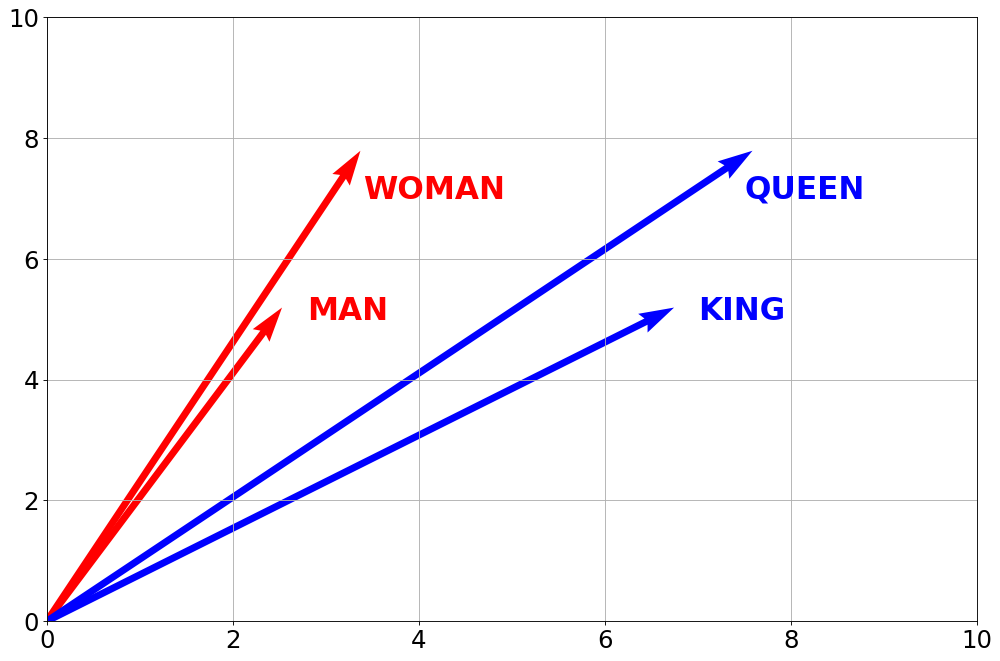
(image from https://medium.com/riga-data-science-club/word-embeddings-by-example-9b067c1d0d33)

Since the difference between the vectors for king and queen is most likely the same difference between man and woman, we can do mathematical operations to derive meaning prediction.


Here is some helpful code that allows us to calculate such comparisons.

In [31]:
from scipy.spatial import distance

def normalize(vec):
    return vec / veclen(vec)

def find_similar_to(vec1, space):
    # vector similarity funciton
    #sim_fn = lambda a, b: 1-distance.euclidean(normalize(a), normalize(b))
    #sim_fn = lambda a, b: 1-distance.correlation(a, b)
    #sim_fn = lambda a, b: 1-distance.cityblock(normalize(a), normalize(b))
    #sim_fn = lambda a, b: 1-distance.chebyshev(normalize(a), normalize(b))
    #sim_fn = lambda a, b: np.dot(normalize(a), normalize(b))
    sim_fn = lambda a, b: 1-distance.cosine(a, b)

    sims = [
        (word2, sim_fn(vec1, space[word2]))
        for word2 in space.keys()
    ]
    return sorted(sims, key = lambda p:p[1], reverse=True)

Here is how you apply this code. Comment on the results you get. **[3 marks]**

In [58]:

'''BL_update for all 3 spaces'''

short = normalize(space_10k['short'])
light = normalize(space_10k['light'])
long = normalize(space_10k['long'])
heavy = normalize(space_10k['heavy'])
print ("for raw space:")
sims = find_similar_to(light - (heavy - long), space_10k)[:10]
print (sims)

short = normalize(ppmispace_10k['short'])
light = normalize(ppmispace_10k['light'])
long = normalize(ppmispace_10k['long'])
heavy = normalize(ppmispace_10k['heavy'])
print ("for PPMI space:")
sims = find_similar_to(light - (heavy - long), ppmispace_10k)[:10]
print(sims)

short = normalize(svdspace_10k['short'])
light = normalize(svdspace_10k['light'])
long = normalize(svdspace_10k['long'])
heavy = normalize(svdspace_10k['heavy'])
print ("for SVD space:")
sims = find_similar_to(light - (heavy - long), svdspace_10k)[:10]
print(sims)



for raw space:
[('long', 0.936140411029304), ('just', 0.9049060246775732), ('normal', 0.897070493693546), ('child', 0.8968235510083787), ('universal', 0.8954682113733906), ('genius', 0.8941840695017294), ('unit', 0.8939911177435964), ('bird', 0.893943608600412), ('light', 0.8930841816879834), ('radical', 0.8928522776983006)]
for PPMI space:
[('long', 0.6455903190370874), ('light', 0.5756309144130762), ('short', 0.22665051391680424), ('about', 0.2062232575609404), ('around', 0.20341064658972596), ('than', 0.1997623801104953), ('longer', 0.19775518996857122), ('through', 0.19530678790677225), ('each', 0.19315737065635885), ('a', 0.1897425288444996)]
for SVD space:
[('long', 0.8733111261346901), ('above', 0.8259671977311955), ('around', 0.8030776291120685), ('sun', 0.7692439111243973), ('just', 0.7678481974778111), ('wide', 0.767257431992253), ('each', 0.7665960260861158), ('circle', 0.7647746702909336), ('length', 0.7601066921319761), ('almost', 0.7542351860536628)]


'BL_update king queen man woman note'

    My guess is that if we have good Correlation Coefficients resulted from our lists then it is possible to predict various phenomena such as antonyms, discussion contexts, in the same way we find similarities between words. We can use linear algebra operations on sets that are presentable in mathematical spaces.

Find 5 similar pairs of pairs of words and test them. Hint: Google for `word analogies examples`. You can also construct analogies that are less lexical but more grammatical, e.g. `see, saw, leave, ?` or analogies that are based on world knowledge as in the [Google analogy dataset](http://download.tensorflow.org/data/questions-words.txt) from [3]. Does the resulting vector similarity confirm your expectations? But remember you can only do this if the words are contained in our vector space with 10,000 dimensions. **[10 marks]**

In [33]:
# Your code should go here...

def based_on_pair_return_similar_to_word(pair1_word1, pair1_word2, pair2_word1):
    print ("'" + pair1_word1 + "' and '" + pair1_word2 + "'" )
    print ("'" + pair2_word1 + "' then:")
    pair1_word1 = normalize(svdspace_10k[pair1_word1])
    pair1_word2 = normalize(svdspace_10k[pair1_word2])
    pair2_word1 = normalize(svdspace_10k[pair2_word1])
    result = find_similar_to(pair1_word1 - pair1_word2 + pair2_word1, svdspace_10k)[:10] #BL_update b1-a1+a2
    #BL_update do for all 3 spaces: raw, ppmi, svd
    for i, word_and_cosSim in enumerate (result):
        print (word_and_cosSim)
    print ("\n\n")
    
based_on_pair_return_similar_to_word("helicopter", "jet", "airplane") #expected truck
based_on_pair_return_similar_to_word("corn", "rice", "apple") #expected peach
based_on_pair_return_similar_to_word("bus", "truck", "bus") #expected train
based_on_pair_return_similar_to_word("guitar", "trumpet", "key") #expected piano
based_on_pair_return_similar_to_word("eagle", "fox", "donkey") #expected horse

'helicopter' and 'jet'
'airplane' then:
('helicopter', 0.9370550278966456)
('airplane', 0.9215108423296754)
('craft', 0.8941106310648328)
('crews', 0.8839852541527036)
('boat', 0.8836199694871517)
('boats', 0.8710809738484855)
('helicopters', 0.863978010410358)
('submarines', 0.8622751191535338)
('patrol', 0.8469179924650048)
('submarine', 0.8463454607238514)



'corn' and 'rice'
'apple' then:
('apple', 0.8977378691903365)
('intel', 0.8784277897113222)
('ipod', 0.8229007239811266)
('console', 0.8163403486272348)
('atari', 0.8162063945256424)
('microsoft', 0.8159230930052944)
('xbox', 0.8102871988080017)
('sony', 0.8070048384972651)
('amd', 0.8059876823676014)
('nintendo', 0.8039671018466545)



'bus' and 'truck'
'bus' then:
('bus', 0.8845658108393816)
('terminal', 0.8122254905203837)
('network', 0.7867169074313085)
('transit', 0.7648003177547797)
('rail', 0.7594777048921911)
('cable', 0.757319657089172)
('telephone', 0.7542540504373751)
('connecting', 0.7534373445036096)
('subway', 0.7

## 5. Semantic composition and phrase similarity **[20 marks]**

In this task, we are going to look at how different semantic composition models, introduced in [2] correlate with human judgements. The file with the dataset is `mitchell_lapata_acl08.txt` included with this notebook. Your task is to do the following:  

(i) process the dataset, extract pairs of `reference - landmark high` and `reference - landmark low`; you can use the code from the lecture as something to start with. Note that there are 2 landmarks for each reference: one landmark exhibits high similarity with the reference, while another one has low similarity with the reference. A single human participant could have evaluated both of these pairs. For more details, we refer you to the paper.  

(ii) build models of semantic phrase composition: in the lecture we introduced simple additive, simple multiplicative and combined models (details are in [2]). Your task is to take a single pair (a reference or a high similarity landmark or a low similarity landmark) and compute the composition of its vectors using each of these functions. Thus, you will have three compositional models that take a `noun - verb` pair and output a single vector, representing the meaning of this pair. As your semantic space, you can use pretrained spaces (standard space, ppmi or svd) introduced above. It is up to you which space you use, but for someone who runs your code, it should be pretty straightforward to switch between them.

(iii) calculate Spearman correlation between each model's predictions and human judgements; you should have something similar to the scores that are shown in the paper [2]:  

![title](./res.png)

The paper states that they calculated correlations between each individual participant's judgeements and each model's predictions.  

Let's say we have 3 models: simple additive (A), simple multiplicative (M), combined (C).  
From our task dataset, we also know that we have 20 participants.  
Now, for each participant in 20 participants we get all `verb - noun` pairs that these participated evaluated.  
For example:

In [ ]:
participant_judgemenets_example = [
 'participant50 chatter child gabble 6 high',
 'participant50 chatter tooth click 2 high',
 'participant50 reel head whirl 5 high',
 'participant50 reel mind stagger 4 low',
 'participant50 reel industry stagger 5 high',
 'participant50 reel man whirl 3 low',
 'participant50 glow fire beam 7 low',
 'participant50 glow face burn 3 low',
 'participant50 glow cigar burn 5 high',
 'participant50 glow skin beam 7 high'
    
]

In [ ]:
participant_judgemenets_example

Let's look at the first pair that participant50 evaluated: reference `child chatter` and high-level similarity landmark (as the last word in the row indicates) `child gabble`. The human gave the similarity score of 6 (very similar). Thus, human similarity judgment = [6].  

Our A model's output:  
cosine(p1, p2) = 0.88, where p1 is the result of addition of word vectors in the reference phrase `child gabble`, and p2 is the result of addition of word vectors in the high-level similarity phrase `child chatter`.  

Therefore, we have human rating vector [6] and model A output [0.88]. Next is to compute correlation between these two vectors.

To get an overall score, simply average your correlation scores over all participants, since you are calculating correlation scores per participant.

Of course, your human rating vectors will be longer (e.g., [6, 7, 3, 4, 5]) where each element is a participant's judgement of a specific pair. Each of your models (A, B, C) will produce a single vector of cosine similarity between these same pairs (e.g., [0.89, 0.98, 0.23, 0.65, 0.55]). The goal is to compare each model's cosine similarity vectors with human rating vectors and identify the model which outputs the best result in terms of being the closest to the way human rate similarity between the phrases.

The minimum to do in this task: compute correlations for 3 models mentioned above and human rating for AT LEAST one participant. Elaborate on how different the resulting correlation scores are depending on the model's composition function (additive, multiplicative, combined). For examples on how to interpret the results, look at Section 5 Results of the original paper.

In [47]:
#your code should go here

dataset = {}
references = []

with open('mitchell_lapata_acl08.txt', 'r') as f:
    phrase_dataset = f.read().splitlines()
    for line in phrase_dataset[1:]:
        participant_id, reference, noun, landmark, rating, hilo = line.split()
        
        reference_phrase = [noun, reference]

        if reference_phrase not in references:
            references.append(reference_phrase)

        landmark_phrase = [noun, landmark]

        if participant_id not in dataset:
            dataset[participant_id] = []
        else:
            dataset[participant_id].append((reference_phrase, landmark_phrase, rating, hilo))
dataset["participant50"]

#for i,participant in enumerate(dataset):
    #print (participant)
    #print (dataset[participant])

#print (references)

#print (dataset["participant20"])
#for i in dataset["participant20"]:
#    print (i)
#    if i[3] == "high":
#        print ("high")

def veclen(vector):
    return math.sqrt(np.sum(np.square(vector)))

def cosine(vector1, vector2):
    veclen1 = veclen(vector1)
    veclen2 = veclen(vector2)
    if veclen1 == 0.0 or veclen2 == 0.0:
        # one of the vectors is empty, the cosine is 0
        return 0.0
    else:
        # we could also simply do:
        dotproduct = np.dot(vector1, vector2)
        return dotproduct / (veclen1 * veclen2)


In [ ]:
'''BL update: pretrained ktw ppk, raw, etc. (Sigrid's) ktw_
calculate_corelation
the models for each of raw, svd, ppmi
'''

In [51]:
example_phrase = references[-3]
print(example_phrase)

['face', 'glow']


In [ ]:
subject_space = our_space[example_phrase[0]]
verb_space = our_space[example_phrase[1]]

In [ ]:
def build_phrase_space(phrase, x_names):

    # first we get representations for verb and noun
    subject_space = our_space[phrase[0]]
    verb_space = our_space[phrase[1]]
    # representation for house and burn
    
    representation = np.zeros(len(x_names))

    for n, word in enumerate(x_names.keys()):

        # I get v^Ith element from each of the vectors
        subject_value = subject_space[word][0]
        verb_value = verb_space[word][0]

        #out = subject_value + verb_value
        #out = subject_value * verb_value
        
        # 6 and 0, if we do summation, we are getting 6
        # if we do mulitplication, we are getting 0
        
        #out = subject_value * 0.2 + verb_value * 0.8
        #out = subject_value * 0.0 + verb_value * 0.95 + (0.05 * subject_value * verb_value)

        representation[n] = out

    return representation

In [48]:
reference = ['face', 'glow']
landmark_high = ['face', 'beam']
landmark_low = ['face', 'burn']

ref = build_phrase_space(reference, dims)

lhigh = build_phrase_space(landmark_high, dims)

llow = build_phrase_space(landmark_low, dims)


print(ref, ref.shape)
print(lhigh)
print(llow)

NameError: name 'build_phrase_space' is not defined

**Any comments/thoughts should go here:**

# Literature

  - [1] C. Silberer and M. Lapata. Learning grounded meaning representations with autoencoders. In Proceedings of the 52nd Annual Meeting of the Association for Computational Linguistics, pages 721–732, Baltimore, Maryland, USA, June 23–25 2014 2014. Association for Computational Linguistics.  

  - [2] Mitchell, J., & Lapata, M. (2008). Vector-based Models of Semantic Composition. In Proceedings of ACL-08: HLT (pp. 236–244). Association for Computational Linguistics.
  
  - [3] T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado, and J. Dean. Distributed representations of words and phrases and their compositionality. In Advances in neural information processing systems, pages 3111–3119, 2013.

## Marks

This assignment has a total of 60 marks.